# Projet sante publique france

## Déjà réalisé

Les données ont été chargée et ont subit un pré-traitement:
   * Les produits ont tous un nom
   * Certains des produits proviennent d'une source fiable est sont donc marqués comme fiables
   * Les données sont désormais dans un fichier `pickle` dans le dossier `data/interim`

## Nettoyage des données 

Les données étant crées par les utilisateurs, les données sont "sales". Il faut retirer toutes les données qui sont des erreurs de saisie.

In [1]:
import os
import random
import re
from pprint import pprint

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import nltk # natural language processing toolkit
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from tabulate import tabulate
import unicodedata
from wordcloud import WordCloud

from src.features.univar import UnivariateAnalysis
from src.features.parsers import UnitParser

plt.rcdefaults()
font = {'size'   : 16}

sns.set()
plt.rc('font', **font)

In [2]:
# On récupère les données du premier traitement
data = pd.read_pickle('../data/interim/products_interim.pickle')
univar = UnivariateAnalysis(data)

In [3]:
trusted_product_count = data[data['trusted_src']]['trusted_src'].count()
total = data.shape[0]
percentage = trusted_product_count / total * 100
print(f'On a donc : {trusted_product_count} produits "trustés" sur : {total} soit : {percentage} %')
del trusted_product_count, total, percentage

On a donc : 1499 produits "trustés" sur : 600654 soit : 0.2495613115037942 %


### Quels sont les champs complétés par les utilisateurs ?

En effet, certains champs sont remplis automatiquement, les timestamps, le créateur, l'url ...
On peut donc regarder les taux de remplissage des différents produits. Les produits les moins complétés seront alors retirés.

In [4]:
fields = list(data.columns)
len(fields)

155

nombre minimum et maximum de champs complétés

In [5]:
data['complete'] = data.count(axis=1)
print(f"Nombre de champs minimum {data['complete'].min()}")
print(f"Nombre de champs complétés au maximum {data['complete'].max()}")

Nombre de champs minimum 18
Nombre de champs complétés au maximum 97


In [6]:
data['complete'] = data['complete'] - data['complete'].min()
data['complete'] = data['complete'] / data['complete'].max() * 100

completion rate -- complete : 100.0 %


mean,std,min,max,median,variance,25%,75%
24.756129742631163,14.568668952776859,0.0,100.0,20.253164556962027,212.24611505560438,16.455696202531644,32.91139240506329


,main_category_en,product_name,complete,complete_mean
1343,fr:lait-de-suite-en-poudre,1,1,94.936709
2119,fr:semoule-lactee-pour-enfants,1,1,88.607595
1346,fr:lait-en-poudre-pour-bebe,1,1,83.544304
2225,fr:subsitut-de-repas-a-boire,1,1,82.278481
1792,fr:poudre,1,1,81.012658
...,...,...,...,...
669,fr:chair-ferme,1,1,34.177215
2137,fr:sirop-epice-gingembrr,1,1,34.177215
1374,fr:legumes-melanges,1,1,34.177215
297,fr:Tournedos de magret de canard,1,1,34.177215


,main_category_en,product_name,complete,complete_mean
415,pt:suplemento-alimentar,1,1,15.189873
293,fr:nourriture-gourmandise,1,1,15.189873
187,fr:coriandre-moulue,1,1,15.189873
195,fr:crement,1,1,15.189873
199,fr:crudites-fraiche,1,1,15.189873
...,...,...,...,...
392,fr:vin-de-france,1,1,6.329114
369,fr:test,1,1,6.329114
225,fr:filet-de-truite,1,1,6.329114
215,fr:eminces-de-champignons,1,1,6.329114


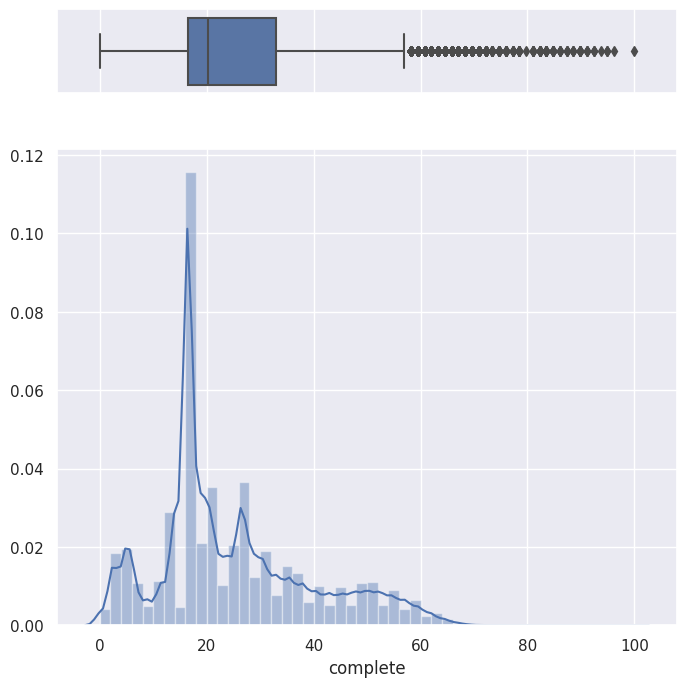

In [7]:
univar.data = data
univar.make_analysis('complete')

regardons les champs de plus près

In [8]:
tab = []
row = []
tab_with = 5
for val in data.columns.values[:-2]:
    if len(row) == tab_with:
        tab.append(row)
        row = []
    row.append(val)
while len(row) < tab_with:
    row.append(None)
tab.append(row)
display(HTML(tabulate(tab, tablefmt='html')))

code,url,creator,created_datetime,last_modified_datetime
product_name,generic_name,quantity,packaging,packaging_tags
brands,brands_tags,categories,categories_tags,categories_en
origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels
labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo
cities_tags,purchase_places,stores,countries,countries_tags
countries_en,ingredients_text,allergens,traces,traces_tags
traces_en,serving_size,serving_quantity,additives_n,additives
additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2
states,states_tags,states_en,main_category,main_category_en


### Temps écoulé entre l'ajout et la dernière modification

#### Motivation

La BDD fonctionne comme wikipédia, chaque produit est vérifié par les pairs. 

Hypothèse : Un produit qui a été modifié à plusieurs reprises a plus de chances d'être correctement complété.

In [9]:
data['dt'] = data['last_modified_datetime'] - data['created_datetime']

In [10]:
data.sort_values(by='dt', ascending=False, inplace=True)

In [11]:
data[['product_name', 'complete', 'dt']]

,product_name,complete,dt
578843,Thoïonade aux olives et aux câpres,48.101266,2831 days 15:15:13
578829,Crème de sardine au whisky,45.569620,2822 days 00:20:03
418061,Boudoirs,58.227848,2819 days 01:52:46
535639,Sainte Maure,46.835443,2809 days 15:50:39
728913,Arroz sushi,43.037975,2803 days 04:30:15
...,...,...,...
610891,Miel De L'Yonne 500g,0.000000,0 days 00:00:00
25901,Cheez-it Baked Snack Crackers,13.924051,0 days 00:00:00
1031437,맛있는 즐거움 포도 100,13.924051,0 days 00:00:00
537740,salade,0.000000,0 days 00:00:00


In [12]:
data['dt'].describe()

count                      600654
mean     292 days 12:20:23.969018
std      426 days 16:17:35.345674
min               0 days 00:00:00
25%               0 days 00:00:09
50%       94 days 12:16:22.500000
75%      450 days 04:43:14.250000
max            2831 days 15:15:13
Name: dt, dtype: object

In [13]:
data['dt'] = data['dt'].map(lambda x : x.total_seconds())
data[['complete', 'dt']].corr()

,complete,dt
complete,1.000000,0.560629
dt,0.560629,1.000000


Pas assez corrélés

In [14]:
data.drop('dt', axis=1, inplace=True)

### Nutrition score

On retire les produits pour lesquels on a pas de nutriscore/nutrigrade (si on a l'un, on a forcément l'autre).

In [15]:
n_prod_without_nutriscore = data[data['nutrition-score-fr_100g'].isna()].shape[0]
n_prod_without_nutrigrade = data[data['nutrition_grade_fr'].isna()].shape[0]
tot_prod = data.shape[0]
assert n_prod_without_nutrigrade == n_prod_without_nutriscore

In [16]:
print('Nombre de produits sans "nutrigrade" : %i soit : %f %%' % (n_prod_without_nutrigrade, 
                                                                 n_prod_without_nutrigrade / tot_prod * 100))
print('Nombre de produits sans "nutriscore" : %i soit : %f %%' % (n_prod_without_nutriscore, 
                                                                 n_prod_without_nutriscore / tot_prod * 100))
data.drop(data[data['nutrition-score-fr_100g'].isna()].index, axis=0, inplace=True)
print("Nombre de produits restants : %i " % data.shape[0])

Nombre de produits sans "nutrigrade" : 412869 soit : 68.736577 %
Nombre de produits sans "nutriscore" : 412869 soit : 68.736577 %
Nombre de produits restants : 187785 


Présence du Nutri-score (ou grade) et pays.

In [17]:
local = data.loc[~data['nutrition-score-fr_100g'].isna()]['countries_tags'].value_counts() \
/ data[~data['nutrition_grade_fr'].isna()].shape[0] * 100
print('Répartition des produits en fonctions des pays.')
local.index = local.index.map(lambda x : x.split(':')[1])
local = local.apply(lambda x : str(x)[:8] + ' %')
local = local.to_string()
print(local)

Répartition des produits en fonctions des pays.
france         95.52253 %
switzerland    2.388902 %
belgium        2.040099 %
luxembourg     0.048459 %


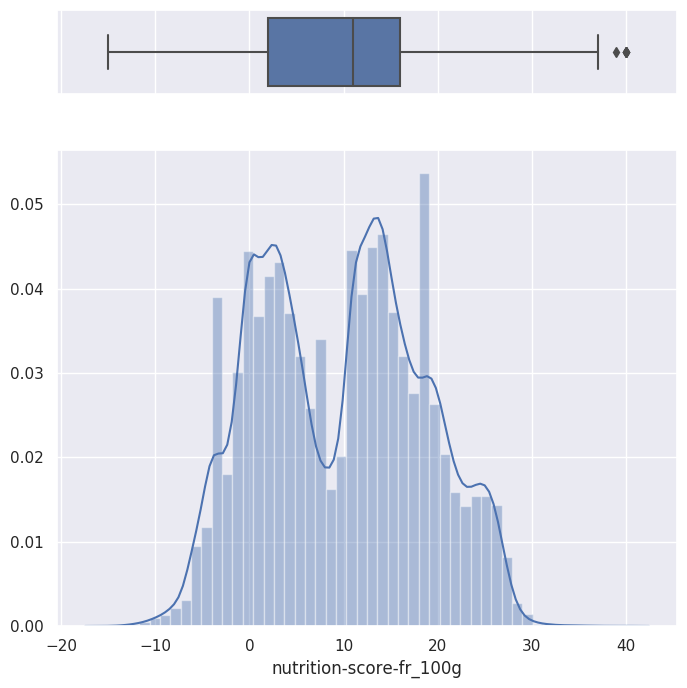

In [18]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(8, 8),
                                    gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data['nutrition-score-fr_100g'], ax=ax_box)
sns.distplot(data['nutrition-score-fr_100g'], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [19]:
cols = ['product_name', 
        'nutrition-score-fr_100g',
        'ingredients_text',
        'brands',
        'nutrition_grade_fr'
       ]
data.sort_values(by='nutrition-score-fr_100g', ascending=False).head()[cols]

,product_name,nutrition-score-fr_100g,ingredients_text,brands,nutrition_grade_fr
697898,whey chocolat,40.0,"Whey protein concentrate (89,5%), Low-fat coco...",Body Attack,e
1037750,Matcha Latte - Green Tea,40.0,NaN,NaN,e
332554,Granulowany napój herbaciany,40.0,Granulowany napéj herbaciany o smaku cytrynowy...,Cynxshno,e
123240,Klik,40.0,NaN,Klik,e
421744,Sprits au beurre,40.0,"Farine de _blé_ (44%), beurre concentré (26 %)...",Belle France,e


Vérifier la correspondance entre le nutriscore et le nutrigrade voir : 
`3.0-tg-univariate-analysis.ipynb`

### Quantité

On commence par supprimer les produits pour lesquels on a pas de quantité

On regarde ensuite si la quantité contient bien une unité (si la case est seulement numérique alors on la drop)

On regarde ensuite si la case n'est pas uniquement du texte 

In [20]:
n_prod_without_quantity = data[data['quantity'].isna()].shape[0]
print('Nombre de produits sans "quantité" : %i soit %f %%' % (n_prod_without_quantity, 
                                                              n_prod_without_quantity / data.shape[0] * 100))
data.drop(data[data['quantity'].isna()].index, axis=0, inplace=True)
print('Nombre de produits restant : %i' % data.shape[0])

Nombre de produits sans "quantité" : 77872 soit 41.468701 %
Nombre de produits restant : 109913


In [21]:
print('Nombre de quantités sans unité : %i' % (data[data['quantity'].apply(lambda s : s.isnumeric())].shape[0]))
data.drop(data[data['quantity'].apply(lambda s : s.isnumeric())].index, axis=0, inplace=True)

Nombre de quantités sans unité : 1398


In [22]:
print('Nombre de produits dont la quantité est textuelle uniquement: %i' % data[data['quantity'].apply(lambda s : s.isalpha())].shape[0])
data.drop(data[data['quantity'].apply(lambda s : s.isalpha())].index, axis=0, inplace=True)

Nombre de produits dont la quantité est textuelle uniquement: 81


Pour la suite, on va normaliser les chaines de caractères en retirant les accents et autres symboles non latin.

Voir `src.features.parsers.py`

In [23]:
data['quantity'] = data['quantity'].apply(UnitParser.normalize_string)

Les quantités sont entrées sans format. Par conséquent, les unités peuvent être exprimées de plusieurs façons ex: "grammes", "gramme", "gr" pour "g", on crée donc un dictionnaire avec les différentes correspondances trouvées.

Voir `src.features.parsers.py`

In [24]:
data['quantity_tuple'] = data['quantity'].apply(UnitParser.parse)

In [25]:
data['quantity'] = data['quantity_tuple']
data.drop('quantity_tuple', axis=1, inplace=True)

In [26]:
print(f"Produits ayant un problème de quantité {data[data['quantity'] == 'Unknown frmt'].shape[0]}")
print(f"Soit {data[data['quantity'] == 'Unknown frmt'].shape[0] / data.shape[0] * 100} %")

Produits ayant un problème de quantité 3881
Soit 3.5791356954460776 %


### Marques

In [27]:
n_prod_without_brands = data[data['brands_tags'].isna()].shape[0]
print('Nombre de produits sans "marque" : %i soit %f %%' % (n_prod_without_brands,
                                                            n_prod_without_brands / data.shape[0]))

Nombre de produits sans "marque" : 4118 soit 0.037977 %


In [28]:
data.drop(data[data['brands_tags'].isna()].index, axis=0, inplace=True)

In [29]:
data['brands_tags'].value_counts().head()

auchan          3325
u               3265
carrefour       3167
casino          2326
leader-price    1983
Name: brands_tags, dtype: int64

### Catégories

In [30]:
for elt in data.columns:
    if 'categ' in elt:
        print('_' * 60)
        print(elt)
        print('_' * 60)
        display(data[elt].head(2))
        print('_' * 60)

____________________________________________________________
categories
____________________________________________________________


578843    Conserves,Viandes,Produits à tartiner,Charcute...
578829    Viandes, Produits à tartiner, Conserves, Plats...
Name: categories, dtype: object

____________________________________________________________
____________________________________________________________
categories_tags
____________________________________________________________


578843    en:canned-foods,en:meats,en:spreads,en:prepare...
578829    en:meats,en:spreads,en:canned-foods,en:prepare...
Name: categories_tags, dtype: object

____________________________________________________________
____________________________________________________________
categories_en
____________________________________________________________


578843    Canned foods,Meats,Spreads,Prepared meats,Salt...
578829    Meats,Spreads,Canned foods,Prepared meats,Salt...
Name: categories_en, dtype: object

____________________________________________________________
____________________________________________________________
main_category
____________________________________________________________


578843    en:canned-foods
578829           en:meats
Name: main_category, dtype: object

____________________________________________________________
____________________________________________________________
main_category_en
____________________________________________________________


578843    Canned foods
578829           Meats
Name: main_category_en, dtype: object

____________________________________________________________


In [31]:
data['main_category_fr'] = data['categories'].apply(lambda x : x.split(',')[0])
data['main_category_fr']

578843                                             Conserves
578829                                               Viandes
418061                                                Snacks
535639                                     Produits laitiers
728913               Aliments et boissons à base de végétaux
                                 ...                        
159153              en:non-carbonated-natural-mineral-waters
1014059    fr:biscuits-aperitifs-souffles-a-base-de-pomme...
400690                                           en:coleslaw
282092                                        fr:Viande porc
315983                                       en:fruit-juices
Name: main_category_fr, Length: 104316, dtype: object

In [32]:
data['main_category_fr'].value_counts()

Aliments et boissons à base de végétaux    23116
Snacks                                     16580
Produits laitiers                           9824
Viandes                                     8268
Plats préparés                              6414
                                           ...  
Vin blanc moelleux                             1
yogourt aux fruits                             1
Palets chocolat                                1
fr:Sodas au cola light                         1
fr:Vegetarien                                  1
Name: main_category_fr, Length: 6199, dtype: int64

In [33]:
len_categ = data['main_category_fr'].apply(len).value_counts().to_dict()

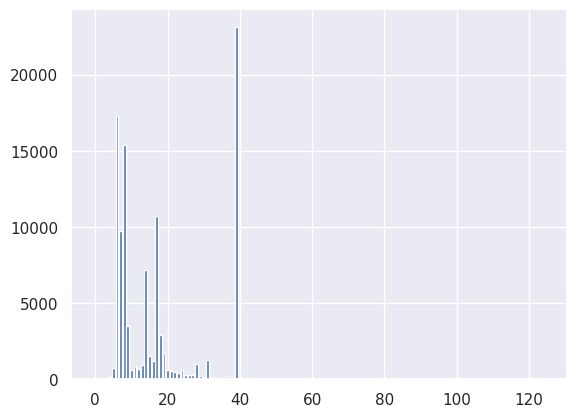

In [34]:
plt.bar(x=list(len_categ.keys()), height=list(len_categ.values()))
plt.show()

In [35]:
def drop_weird_category(categ_str, max_len=60):
    e = 'error'
    if type(categ_str) != str:
        return e
    elif ':' in categ_str:
        return e
    elif len(categ_str) > max_len:
        return e
    else:
        return categ_str

In [36]:
data['main_category_fr'] = data['main_category_fr'].apply(drop_weird_category)
categ_count = data['main_category_fr'].value_counts()
print(f"Nombre de catégories problématiques : {data[data['main_category_fr'] == 'error'].count().values[0]}")

Nombre de catégories problématiques : 3545


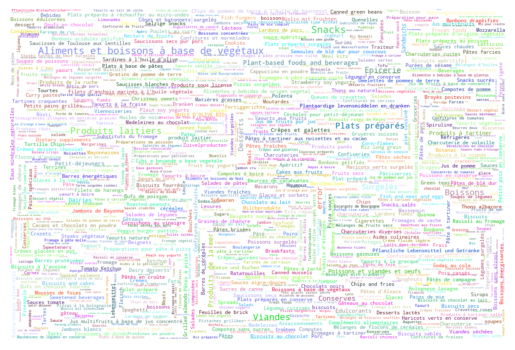

In [37]:
random_state = 31
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    red = random.randint(0, 100)
    green = random.randint(0, 100) 
    blue = random.randint(0, 100)
    return "rgb(%d%%, %d%%, %d%%)" % (red, green, blue)

wordcloud_kwrgs = dict(width=1200, height=800, 
                       margin=0, background_color='white', 
                       min_font_size=3, max_font_size=24,
                       relative_scaling=0.16, max_words=1000,
                       random_state=random_state)
wordcloud = WordCloud(**wordcloud_kwrgs).generate_from_frequencies(categ_count.to_dict())
wordcloud.to_file('./test.png')
# Display the generated image:
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=random_state), 
           interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [38]:
categ_count[categ_count > 1].to_dict()

{'Aliments et boissons à base de végétaux': 23116,
 'Snacks': 16580,
 'Produits laitiers': 9824,
 'Viandes': 8268,
 'Plats préparés': 6414,
 'Boissons': 6168,
 'Epicerie': 3677,
 'error': 3545,
 'Surgelés': 2709,
 'Desserts': 2097,
 'Conserves': 1963,
 'Produits de la mer': 1563,
 'Plant-based foods and beverages': 1116,
 'Sandwichs': 814,
 'Poissons et viandes et oeufs': 769,
 'Dairies': 696,
 'Produits à tartiner': 685,
 'Petit-déjeuners': 519,
 'Édulcorants': 407,
 'Crêpes et galettes': 369,
 'Meals': 273,
 'Compléments alimentaires': 242,
 'Matières grasses': 223,
 "Produits d'élevages": 190,
 'Tartes': 158,
 'Meats': 151,
 'Biscuits et gâteaux': 148,
 'Aides culinaires': 140,
 'Beverages': 123,
 'Pflanzliche Lebensmittel und Getränke': 122,
 'Terrines': 103,
 'Groceries': 96,
 'Pâtes à tarte': 91,
 'Jambons blancs': 76,
 'Laits de coco': 71,
 'Pizzas': 67,
 'Pâtes à pizza': 59,
 'Seafood': 59,
 'Milchprodukte': 58,
 'Frozen foods': 55,
 'Sirops': 54,
 'Getränke': 53,
 'Chips et fr

In [39]:
data['main_category_en'] = data['main_category_en'].apply(drop_weird_category)

In [40]:
categories = data['main_category_en'].value_counts()

In [41]:
categories = categories.loc[[x for x in categories.index if ':' not in str(x)]]

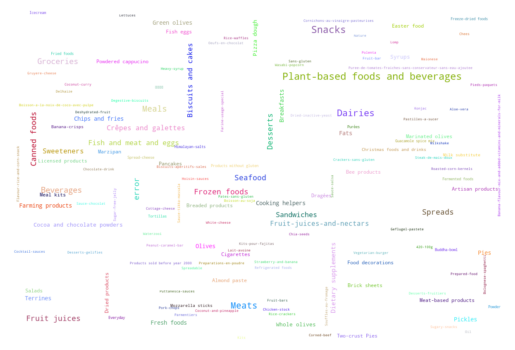

In [42]:
random_state = 31
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    red = random.randint(0, 100)
    green = random.randint(0, 100) 
    blue = random.randint(0, 100)
    return "rgb(%d%%, %d%%, %d%%)" % (red, green, blue)

wordcloud_kwrgs = dict(width=1200, height=800, 
                       margin=0, background_color='white', 
                       min_font_size=3, max_font_size=24,
                       relative_scaling=0.16, max_words=1000,
                       random_state=random_state)
wordcloud = WordCloud(**wordcloud_kwrgs).generate_from_frequencies(categories.to_dict())

# Display the generated image:
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=random_state), 
           interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Histo

### Valeurs \*_100g

In [43]:
data.shape[0]

104316

In [44]:
univar.data = data

In [45]:
data['energy_100g'].describe()

count    1.040450e+05
mean     4.505201e+03
std      1.071785e+06
min      0.000000e+00
25%      4.670000e+02
50%      1.029000e+03
75%      1.640000e+03
max      3.456712e+08
Name: energy_100g, dtype: float64

completion rate -- energy_100g : 99.74021243145826 %


mean,std,min,max,median,variance,25%,75%
4505.201275371233,1071785.2141246197,0.0,345671211.0,1029.0,1148723545216.1567,467.0,1640.0


,main_category_en,product_name,energy_100g,energy_100g_mean
46,Meats,899,899,386432.008343
71,error,600,600,11471.950000
57,Products sold before year 2000,1,1,3770.000000
48,Oil,1,1,3700.000000
7,Breaded products,1,1,3594.000000
...,...,...,...,...
39,Gruyere-cheese,1,1,1703.000000
4,Bee products,5,5,1688.400000
66,Sweeteners,293,293,1680.174061
35,Fruit juices,1,1,1665.000000


,main_category_en,product_name,energy_100g,energy_100g_mean
60,Spreadable,1,1,446.000000
16,Cottage-cheese,1,1,435.000000
11,Christmas foods and drinks,1,1,418.000000
43,Meats,1056,1056,417.401515
67,Waterzooi,1,1,410.000000
...,...,...,...,...
36,Konjac,1,1,29.000000
20,Desserts-gelifies,1,1,21.000000
63,Sugar-free-jelly,1,1,4.000000
35,Himalayan-salts,2,2,2.000000


/home/thibault/Documents/openclassrooms/projects/sante_publique_france/src/features/univar.py:57: UserWarning:

NaN detected in the series. NaNs are not considered for calculation.



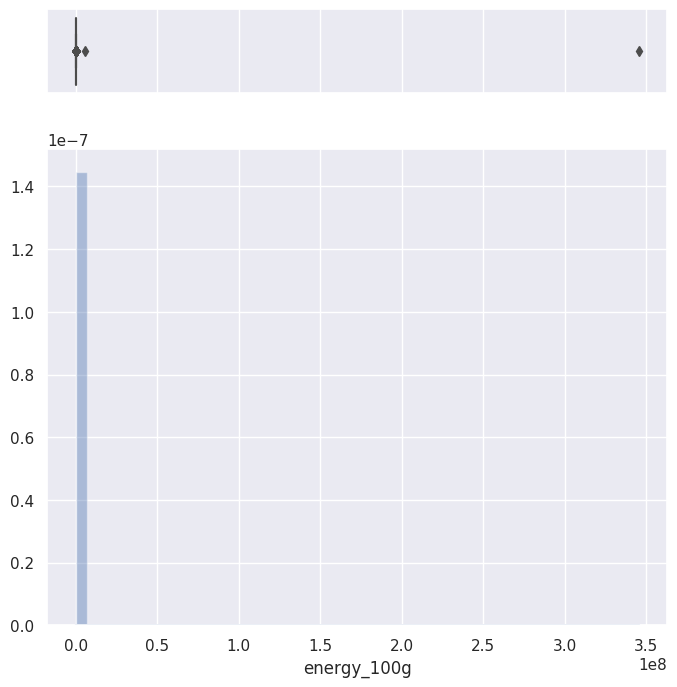

In [46]:
univar.make_analysis('energy_100g')

In [47]:
data[data['energy_100g'] == 0]

,code,url,creator,created_datetime,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,...,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,trusted_src,complete,main_category_fr
587880,3700123300380,http://world-en.openfoodfacts.org/product/3700...,guyomq,2012-05-30 11:56:59,2019-11-23 11:43:33,Pure Life,Eau minérale,"(50.0, cl)","Bouteille plastique,Plastique,bouchon,recyclable","bouteille-plastique,plastique,bouchon,recyclable",...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,45.569620,Boissons
318817,26003481,http://world-en.openfoodfacts.org/product/2600...,stephane,2012-09-16 12:35:06,2019-11-07 21:33:28,Eau de source Arcens Rocheval,Eau Minérale Naturelle renforcée au gaz de la ...,"(1.25, l)","Bouteille,Plastique,Plastique recyclable","bouteille,plastique,plastique-recyclable",...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,False,45.569620,Boissons
540038,3546635007382,http://world-en.openfoodfacts.org/product/3546...,nounours,2012-06-20 11:43:46,2019-06-26 23:20:18,Abatilles Sainte Anne &quot;la Bordelaise&quot;,eau minérale naturelle,"(1.0, l)",bouteille plastique,bouteille-plastique,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,49.367089,Boissons
395707,3245411377816,http://world-en.openfoodfacts.org/product/3245...,dentdelion,2012-07-01 12:17:35,2019-06-15 16:31:29,Les aromatisées,Boisson à l'eau minérale naturelle aromatisée ...,"(1.5, l)","Bouteille,Plastique","bouteille,plastique",...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,56.962025,Boissons
398979,3250390145769,http://world-en.openfoodfacts.org/product/3250...,openfoodfacts-contributors,2012-12-12 20:06:19,2019-09-25 17:39:54,Ondine eau de source,eau de source,"(1.5, l)","Bouteille,plastique","bouteille,plastique",...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,44.303797,Boissons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135183,0108256925,http://world-en.openfoodfacts.org/product/0108...,openfoodfacts-contributors,2019-08-15 20:32:08,2019-08-15 20:33:10,Nike,NaN,Unknown frmt,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,32.911392,error
1054270,9782848018690,http://world-en.openfoodfacts.org/product/9782...,openfoodfacts-contributors,2019-06-14 20:57:21,2019-06-14 20:58:17,Pizza,NaN,"(1000.0, g)",NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,30.379747,error
352417,3045050235054,http://world-en.openfoodfacts.org/product/3045...,openfoodfacts-contributors,2019-08-15 20:28:18,2019-08-15 20:29:11,Cartable pas cher,NaN,"(600.0, g)",NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,30.379747,error
135177,0108087515,http://world-en.openfoodfacts.org/product/0108...,openfoodfacts-contributors,2019-08-15 20:36:14,2019-08-15 20:36:57,Nike pas cher 30€,NaN,Unknown frmt,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,30.379747,error


completion rate -- energy_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
1125.4859196814189,770.8945871561889,0.0,3799.0,1029.0,594278.4645067109,467.0,1640.0


,main_category_en,product_name,energy_100g,energy_100g_mean
57,Products sold before year 2000,1,1,3770.000000
48,Oil,1,1,3700.000000
7,Breaded products,1,1,3594.000000
27,Fats,204,204,3306.980392
41,Maionese,1,1,2694.000000
...,...,...,...,...
39,Gruyere-cheese,1,1,1703.000000
4,Bee products,5,5,1688.400000
66,Sweeteners,293,293,1680.174061
35,Fruit juices,1,1,1665.000000


,main_category_en,product_name,energy_100g,energy_100g_mean
60,Spreadable,1,1,446.000000
16,Cottage-cheese,1,1,435.000000
11,Christmas foods and drinks,1,1,418.000000
43,Meats,1056,1056,417.401515
67,Waterzooi,1,1,410.000000
...,...,...,...,...
36,Konjac,1,1,29.000000
20,Desserts-gelifies,1,1,21.000000
63,Sugar-free-jelly,1,1,4.000000
35,Himalayan-salts,2,2,2.000000


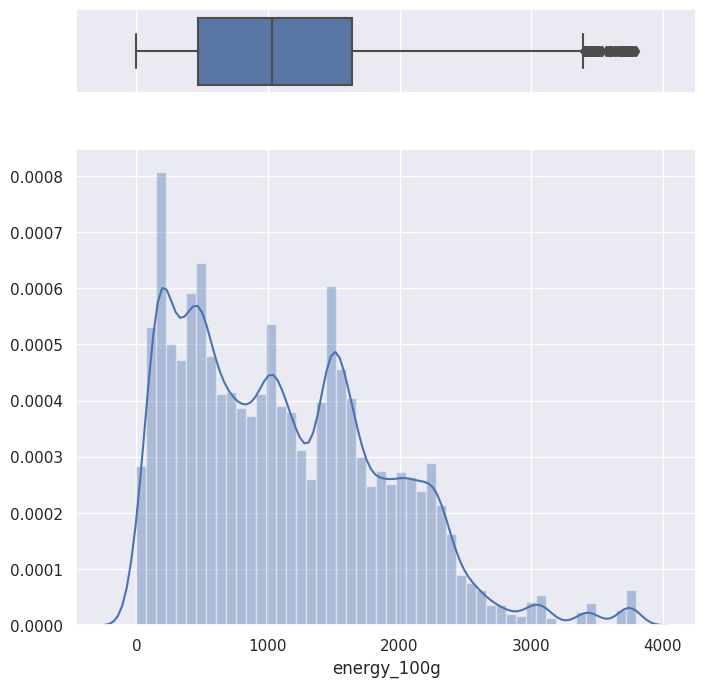

In [48]:
data = data[data['energy_100g'] < 3800]
univar.data = data
univar.make_analysis('energy_100g')

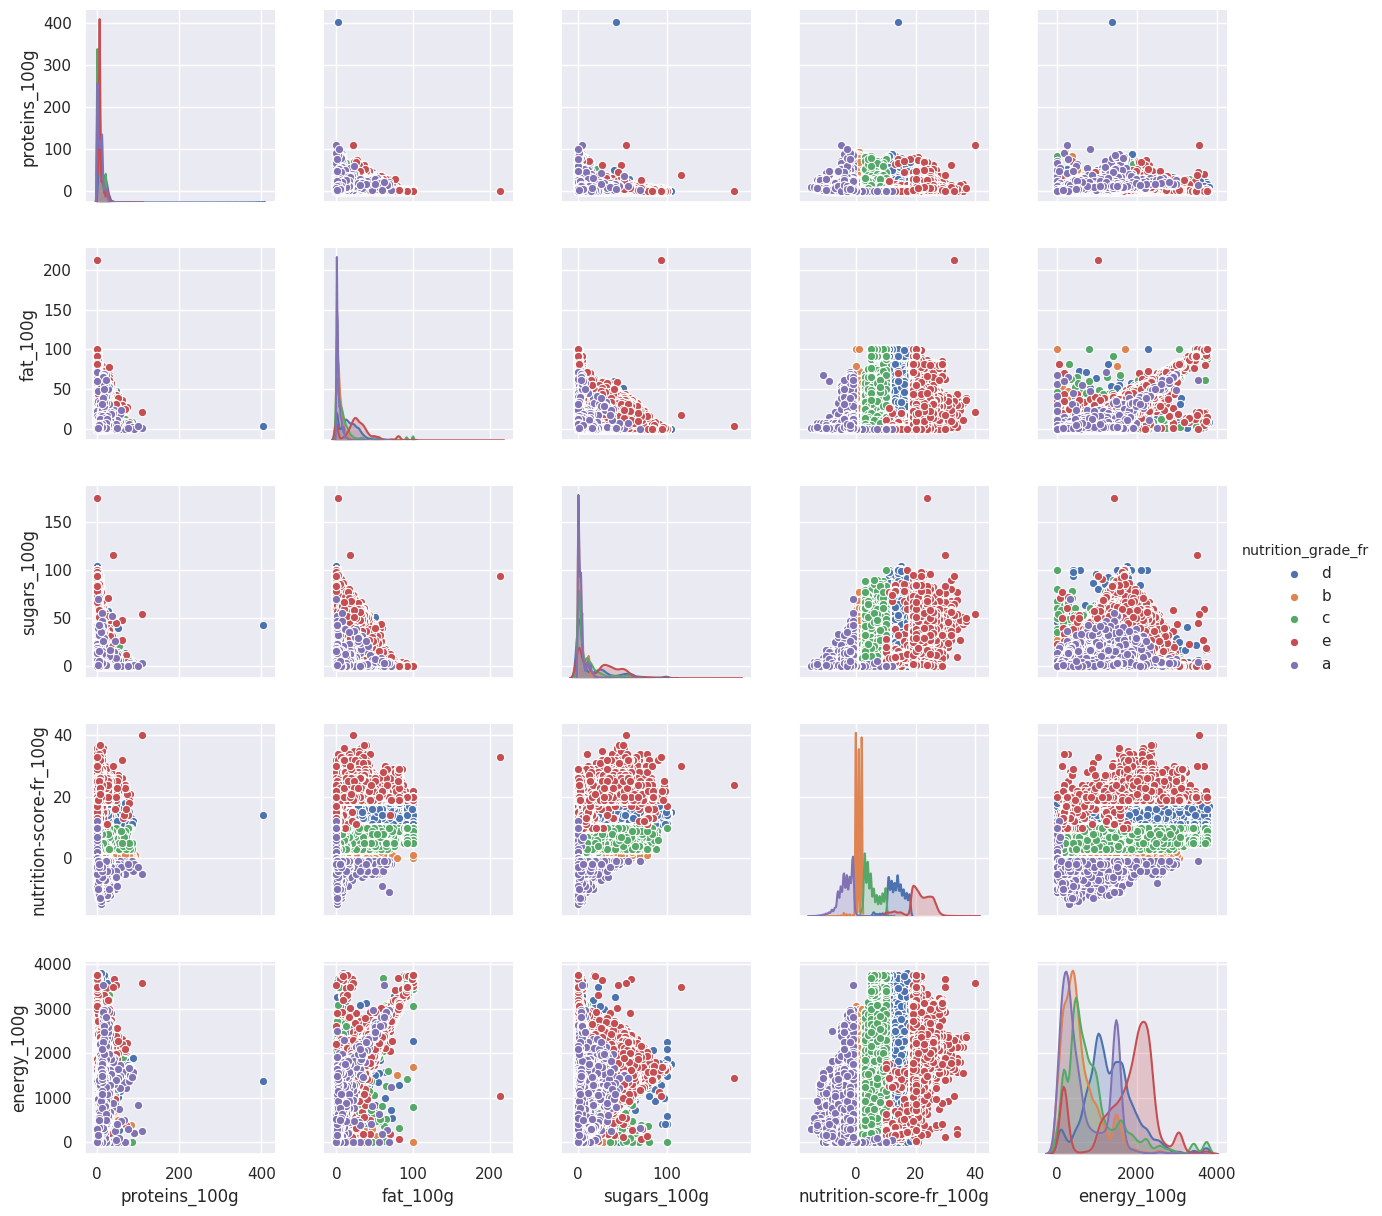

In [49]:
compo = univar.data[['product_name', 'proteins_100g', 
                     'fat_100g', 'sugars_100g', 'nutrition_grade_fr', 
                     'nutrition-score-fr_100g', 'energy_100g']].copy()
compo.dropna(axis=0, inplace=True)
sns.pairplot(data=compo, hue='nutrition_grade_fr')
plt.show()

tableau de contingence.

### Code

Est ce qu'il y a des doublons? 

In [50]:
print('Nombre de doublons : %i' % (data['code'].shape[0] - data['code'].drop_duplicates().shape[0]))
data['code'].drop_duplicates(inplace=True)

Nombre de doublons : 2


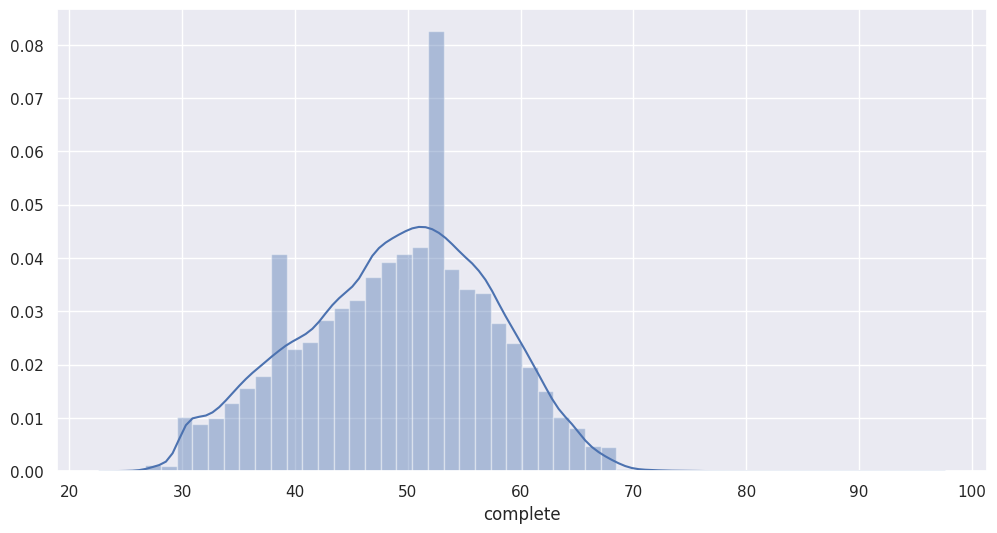

In [51]:
plt.figure(figsize=(12, 6))
sns.distplot(data['complete'])
plt.show()

In [52]:
data = data[['code', 'product_name', 'brands', 
             'main_category_en', 'main_category_fr', 
             'quantity', 'energy_100g',
             'proteins_100g', 'sugars_100g', 'fat_100g',
             'nutrition-score-fr_100g', 'nutrition_grade_fr',
             'complete', 'trusted_src']]

In [53]:
for elt in data.columns:
    if 'categ' in elt:
        print(elt)

main_category_en
main_category_fr


### Sauvegarde 

In [54]:
print(f"Le fichier contient maintenant {data.shape[0]} lignes et {data.shape[1]} colonnes")

Le fichier contient maintenant 103961 lignes et 14 colonnes


In [55]:
data.to_pickle("../data/interim/products_interimV2.pickle")